In [1]:
import os
import dotenv
import pickle
import pandas as pd
import numpy as np

import catboost as cb
import shap
shap.initjs()

from sklearn.model_selection import train_test_split
#from sklearn.inspection import plot_partial_dependence

import matplotlib.pyplot as plt
%matplotlib inline

Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)


In [2]:
# Load environment variables
project_dir = os.path.join(os.path.abspath(''), os.pardir)
dotenv_path = os.path.join(project_dir, '.env')

dotenv.load_dotenv(dotenv_path)

True

In [3]:
df = pd.read_csv(os.path.join(os.getenv('PROCESSED_DATA_FILES'), 'df_train_test.csv'), encoding='UTF-8')

In [27]:
X = df.loc[:, ["post_id", "log_init_imps", "log_init_engs", "Dominant_Topic", "Keywords"]]
X = X.set_index('post_id')
X['Keywords'] = X['Keywords'].apply(lambda x: x[1:] if x.startswith(',') else x)#.str.split(',')
X['Dominant_Topic'] = X['Dominant_Topic'].astype(int)

y = df.loc[:, ["post_id", "log_all_engrate"]]
y = y.set_index('post_id')
y = y.squeeze()

In [28]:
X_train_1, X_test_1, y_train_1, y_test_1 = train_test_split(X, y, test_size=0.2, random_state=42, stratify=df.class_weight.values.tolist())

In [6]:
data_pool = cb.Pool(data=X_train, label=y_train, cat_features=['Keywords', 'Dominant_Topic'])

In [20]:
X = df.loc[:, ["post_id", "log_init_imps", "log_init_engs", "Dominant_Topic", "Keywords"]]
X = X.set_index('post_id')
X = pd.concat([X.drop(columns=['Keywords']), X['Keywords'].str.get_dummies(sep=",")], axis=1)
X = pd.concat([X.drop(columns=['Dominant_Topic']), X['Dominant_Topic'].astype(str).str.get_dummies()], axis=1)
#X = pd.concat([df_ready.drop(columns=['Keywords']), df_ready['Keywords'].str.get_dummies(sep=",")], axis=1)
#X = pd.concat([df_ready.drop(columns=['Dominant_Topic']), df_ready['Dominant_Topic'].str.get_dummies()], axis=1)
y = df.loc[:, ["post_id", "log_all_engrate"]]
y = y.set_index('post_id')
y = y.squeeze()
print(X.head())
print(y.head())

                                                    log_init_imps  \
post_id                                                             
0958b102f46bf30d0fd0b066164da0b7b7bed762c4d7b75...       8.836810   
0e16a8e384fe24d1b936336efd87a978fd36ef241205a12...      10.852304   
149644004573512a361a5d89ab8c9003080a3af20fca364...       9.495219   
27df549b4d17af132fb603068a3cb64376aa9824193b8ff...       8.348538   
2a0d916a2d052d0d7adc424c8cb6c2c8f8e6e5da04f546d...       7.942007   

                                                    log_init_engs  approach  \
post_id                                                                       
0958b102f46bf30d0fd0b066164da0b7b7bed762c4d7b75...       5.420535         0   
0e16a8e384fe24d1b936336efd87a978fd36ef241205a12...       8.478660         0   
149644004573512a361a5d89ab8c9003080a3af20fca364...       5.988961         0   
27df549b4d17af132fb603068a3cb64376aa9824193b8ff...       6.570883         0   
2a0d916a2d052d0d7adc424c8cb6c2c8f8e6e5da04

In [21]:
X_train_2, X_test_2, y_train_2, y_test_2 = train_test_split(X, y, test_size=0.2, random_state=42, stratify=df.class_weight.values.tolist())

In [7]:
# Load the model
with open(os.path.join(os.getenv('TRAINED_MODELS_PATH'), 'decision_tree_model.pkl'), 'rb') as file:
    dt_m = pickle.load(file)

In [8]:
# Load the model
cb_m = cb.CatBoostRegressor()
cb_m.load_model(os.path.join(os.getenv('TRAINED_MODELS_PATH'), 'catboost_model.bin'))

In [22]:
# Create SHAP explainer objects
exp_dt_m = shap.TreeExplainer(dt_m)

exp_cb_m = shap.TreeExplainer(cb_m)

In [23]:
# Calculate SHAP values
sample_index = 0  # Replace with the index of the sample you want to explain

shap_values_dt = exp_dt_m.shap_values(X_train_2)
shap_values_cb = exp_cb_m.shap_values(data_pool)

In [37]:
exp_cb_m.expected_value

0.5587548045484002

In [30]:
# visualize the first prediction's explanation
shap.force_plot(exp_dt_m.expected_value, shap_values_dt[0,:], X_train_2.iloc[0,:])

In [29]:
# visualize the first prediction's explanation
shap.force_plot(exp_cb_m.expected_value, shap_values_cb[0,:], X_train_1.iloc[0,:])

In [32]:
num_samples = 100
X_subsampled_2 = X_train_2.sample(num_samples, random_state=42)

# Subsample the corresponding SHAP values
shap_values_subsampled_2 = shap_values_dt[:num_samples]
# visualize the training set predictions
shap.force_plot(exp_dt_m.expected_value, shap_values_subsampled_2, X_subsampled_2)

In [15]:
num_samples = 100
X_subsampled = X_train.sample(num_samples, random_state=42)

# Subsample the corresponding SHAP values
shap_values_subsampled = shap_values_cb[:num_samples]

# visualize the training set predictions
shap.force_plot(exp_cb_m.expected_value, shap_values_subsampled, X_subsampled)

No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored


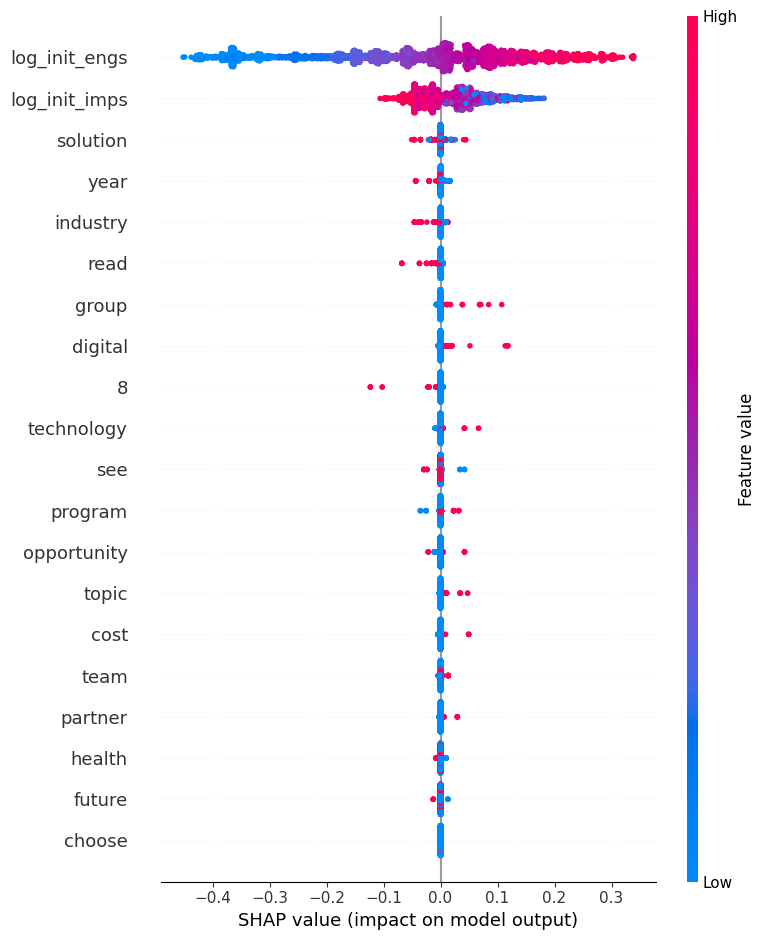

In [33]:
shap.summary_plot(shap_values_dt, X_train_2)

No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored


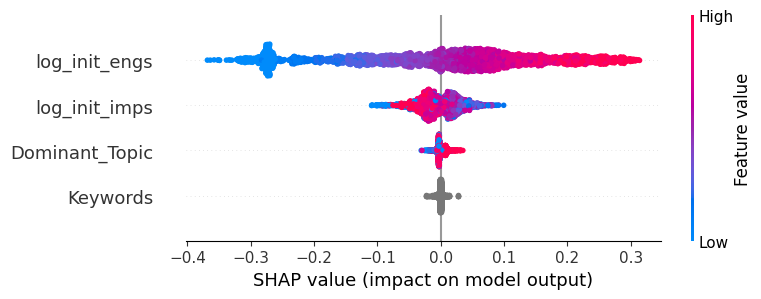

In [34]:
# Visualize the SHAP values
# Summary plot for Model 1
#shap.summary_plot(shap_values_dt, X.iloc[sample_index])
#plt.title("SHAP Values - RegressionTree")
# Summary plot for Model 2
shap.summary_plot(shap_values_cb, X_train_1)

In [36]:
# Compare individual SHAP values
shap.dependence_plot(0, shap_values_dt, X.iloc[0])
shap.dependence_plot(0, shap_values_cb, X.iloc[0])

TypeError: order must be str, not int

In [ ]:
# SHAP Force Plot Comparison
shap.force_plot(explainer_model1.expected_value, shap_values_dt, X.iloc[sample_index], show=False)
plt.title("SHAP Force Plot - RegressionTree")

shap.force_plot(explainer_model2.expected_value, shap_values_cb, X.iloc[sample_index], show=False)
plt.title("SHAP Force Plot - CatboostRegression")

plt.show()

In [ ]:
# Partial Dependence Plot Comparison
fig, ax = plt.subplots(figsize=(12, 4))
plot_partial_dependence(dt_m, X, features=[0, 1], ax=ax)
plt.title("Partial Dependence Plots - RegressionTree")

fig, ax = plt.subplots(figsize=(12, 4))
plot_partial_dependence(cb_m, X, features=[0, 1], ax=ax)
plt.title("Partial Dependence Plots - CatboostRegression")

plt.show()

In [ ]:
# Prediction Comparison Plot
plt.figure(figsize=(8, 6))
plt.scatter(y_test, y_pred_model1, color='blue', alpha=0.5, label='RegressionTree Predictions')
plt.scatter(y_test, y_pred_model2, color='red', alpha=0.5, label='CatboostRegression Predictions')
plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], color='black', linestyle='--', lw=2)
plt.xlabel('True Values')
plt.ylabel('Predictions')
plt.title('Prediction Comparison')
plt.legend()
plt.show()